# BitcoinBot: Educational Algorithmic Trading Notebook

This notebook walks you through building a realistic, explainable Bitcoin trading bot using Python, machine learning, and backtesting.

---

## 1. Data Fetching
We'll use the CoinGecko API to fetch recent Bitcoin price data at minute resolution.

In [21]:
import requests
import pandas as pd
import time
import numpy as np

def fetch_coingecko_data(symbol='bitcoin', vs_currency='usd', days=1):
    url = f'https://api.coingecko.com/api/v3/coins/{symbol}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days
    }
    headers = {
        'User-Agent': 'Mozilla/5.0 (compatible; BitcoinBot/1.0; +https://github.com/yourusername/bitcoinbot)'
    }
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    data = response.json()
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open'] = df['close'].shift(1)
    df['high'] = df[['open', 'close']].max(axis=1)
    df['low'] = df[['open', 'close']].min(axis=1)
    df = df.dropna().reset_index(drop=True)
    return df

def calculate_technical_indicators(df):
    """Calculate technical indicators for feature engineering"""
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_histogram'] = df['macd'] - df['macd_signal']
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    
    # Price changes
    df['price_change_1'] = df['close'].pct_change(1)
    df['price_change_5'] = df['close'].pct_change(5)
    df['price_change_10'] = df['close'].pct_change(10)
    
    return df

# Fetch and process data
df = fetch_coingecko_data(days=1)
df = calculate_technical_indicators(df)
df = df.dropna().reset_index(drop=True)
print(f"Data shape: {df.shape}")
df.head()

Data shape: (267, 19)


,timestamp,close,open,high,low,sma_5,sma_20,ema_12,ema_26,rsi,macd,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,price_change_1,price_change_5,price_change_10
0,2025-06-24 04:15:43.509,104909.024076,104977.589683,104977.589683,104909.024076,104985.709888,104997.270003,104995.151097,104999.098683,51.557354,-3.947586,4.631292,-8.578877,104997.270003,105121.536036,104873.003971,-0.000653,-0.000799,-0.001666
1,2025-06-24 04:21:25.490,104848.481449,104909.024076,104909.024076,104848.481449,104951.442660,104988.648496,104971.889797,104985.176037,41.551757,-13.286240,1.014426,-14.300665,104988.648496,105128.905571,104848.391421,-0.000577,-0.001631,-0.002456
2,2025-06-24 04:26:20.391,104905.688332,104848.481449,104905.688332,104848.481449,104929.966002,104983.722113,104961.440113,104977.960904,47.657015,-16.520790,-2.518687,-14.002103,104983.722113,105128.524613,104838.919612,0.000546,-0.001023,-0.001763
3,2025-06-24 04:31:35.743,104971.516506,104905.688332,104971.516506,104905.688332,104922.460009,104982.508672,104963.024301,104977.385549,48.704966,-14.361248,-4.901264,-9.459984,104982.508672,105127.292277,104837.725068,0.000627,-0.000357,-0.001097
4,2025-06-24 04:37:17.787,104967.785990,104971.516506,104971.516506,104967.785990,104920.499271,104983.203220,104963.770408,104976.541339,37.390701,-12.770932,-6.482665,-6.288266,104983.203220,105127.541461,104838.864980,-0.000036,-0.000093,-0.000461


## 2. Feature Engineering
We'll add technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands) to help our model.

In [22]:
def calculate_technical_indicators(df):
    df['sma_5'] = df['close'].rolling(window=5).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['ema_12'] = df['close'].ewm(span=12).mean()
    df['ema_26'] = df['close'].ewm(span=26).mean()
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9).mean()
    df['macd_histogram'] = df['macd'] - df['macd_signal']
    df['bb_middle'] = df['close'].rolling(window=20).mean()
    bb_std = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['price_change_1'] = df['close'].pct_change(1)
    df['price_change_5'] = df['close'].pct_change(5)
    df['price_change_10'] = df['close'].pct_change(10)
    return df

df = calculate_technical_indicators(df)
df = df.dropna().reset_index(drop=True)
df.head()

,timestamp,close,open,high,low,sma_5,sma_20,ema_12,ema_26,rsi,macd,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,price_change_1,price_change_5,price_change_10
0,2025-06-24 05:52:36.408,105355.958231,105342.794952,105355.958231,105342.794952,105292.823331,105047.172113,105182.860149,105112.542751,88.446185,70.317399,41.535506,28.781893,105047.172113,105369.947115,104724.397112,0.000125,0.002257,0.004158
1,2025-06-24 05:56:47.316,105414.676084,105355.958231,105414.676084,105355.958231,105336.077769,105072.454714,105219.625357,105140.471131,95.861438,79.154226,49.129290,30.024936,105072.454714,105427.289790,104717.619638,0.000557,0.002056,0.004258
2,2025-06-24 06:02:01.125,105447.112745,105414.676084,105447.112745,105414.676084,105378.450876,105102.386279,105255.533494,105168.305123,95.939322,87.228370,56.805749,30.422622,105102.386279,105478.053914,104726.718643,0.000308,0.002013,0.004364
3,2025-06-24 06:05:46.682,105453.194150,105447.112745,105453.194150,105447.112745,105402.747232,105129.761570,105286.609258,105193.739955,99.024793,92.869304,64.061289,28.808015,105129.761570,105524.393248,104735.129891,0.000058,0.001153,0.003709
4,2025-06-24 06:11:47.255,105452.909130,105453.194150,105453.194150,105452.909130,105424.770068,105153.831201,105312.666696,105216.531955,99.946607,96.134741,70.506415,25.628326,105153.831201,105566.150232,104741.512170,-0.000003,0.001045,0.003607


## 3. Model Training
We'll use a Random Forest Regressor to predict the next close price.

In [29]:
from sklearn.ensemble import RandomForestRegressor

feature_columns = [
    'close', 'high', 'low', 'open',
    'sma_5', 'sma_20', 'ema_12', 'ema_26',
    'rsi', 'macd', 'macd_signal', 'macd_histogram',
    'bb_upper', 'bb_lower', 'bb_middle',
    'price_change_1', 'price_change_5', 'price_change_10'
]

df['next_output'] = df['close'].shift(-1)
df = df.dropna().reset_index(drop=True)

WINDOW = 120
X = df[feature_columns]
y = df['next_output']

# Use the last WINDOW points for testing
X_train, X_test = X.iloc[:-WINDOW], X.iloc[-WINDOW:]
y_train, y_test = y.iloc[:-WINDOW], y.iloc[-WINDOW:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f'Train R^2: {model.score(X_train, y_train):.3f}')
print(f'Test R^2: {model.score(X_test, y_test):.3f}')

Train R^2: 0.988
Test R^2: -2.019


## 4. Backtesting
We'll simulate trading with realistic fees and slippage.

In [30]:
FEE_RATE = 0.001
SLIPPAGE_RATE = 0.0005
HOLD_THRESHOLD = 0.005
INITIAL_CASH = 500000

cash = INITIAL_CASH
btc = 0.0
portfolio_values = []
trade_log = []

for i in range(WINDOW, len(df) - 1):
    X_window = df[feature_columns].iloc[i-WINDOW:i]
    y_window = df['next_output'].iloc[i-WINDOW:i]
    X_pred = df[feature_columns].iloc[i+1:i+2]
    current_price = df['close'].iloc[i+1]
    current_time = df['timestamp'].iloc[i+1]
    
    model.fit(X_window, y_window)
    pred = model.predict(X_pred)[0]
    pct_move = (pred - current_price) / current_price
    trade_action = 'HOLD'
    if pct_move > HOLD_THRESHOLD and cash > 0:
        buy_price = current_price * (1 + SLIPPAGE_RATE * np.random.rand())
        btc_to_buy = (cash / buy_price)
        fee = btc_to_buy * FEE_RATE
        btc_to_buy -= fee
        btc += btc_to_buy
        cash = 0
        trade_action = 'BUY'
        trade_log.append((current_time, 'BUY', buy_price, btc_to_buy, fee * buy_price))
    elif pct_move < -HOLD_THRESHOLD and btc > 0:
        sell_price = current_price * (1 - SLIPPAGE_RATE * np.random.rand())
        fee = btc * sell_price * FEE_RATE
        cash = btc * sell_price - fee
        btc = 0
        trade_action = 'SELL'
        trade_log.append((current_time, 'SELL', sell_price, btc, fee))
    portfolio_value = cash + btc * current_price
    portfolio_values.append(portfolio_value)
    if i % 10 == 0:
        print(f'{current_time} - Price: ${current_price:,.2f}, Predicted Move: {pct_move:+.4f}%, Action: {trade_action}')

2025-06-24 15:56:05.499000 - Price: $105,353.28, Predicted Move: -0.0001%, Action: HOLD
2025-06-24 16:45:58.627000 - Price: $105,669.25, Predicted Move: -0.0010%, Action: HOLD
2025-06-24 17:35:53.507000 - Price: $105,800.63, Predicted Move: -0.0004%, Action: HOLD
2025-06-24 18:25:15.749000 - Price: $105,827.46, Predicted Move: +0.0004%, Action: HOLD
2025-06-24 19:15:28.666000 - Price: $105,491.01, Predicted Move: +0.0002%, Action: HOLD
2025-06-24 20:08:40.028000 - Price: $105,594.84, Predicted Move: -0.0002%, Action: HOLD
2025-06-24 20:56:11.050000 - Price: $106,014.85, Predicted Move: +0.0000%, Action: HOLD
2025-06-24 21:45:35.187000 - Price: $105,963.87, Predicted Move: -0.0002%, Action: HOLD
2025-06-24 22:36:17.153000 - Price: $105,916.75, Predicted Move: +0.0003%, Action: HOLD
2025-06-24 23:25:57.270000 - Price: $105,864.43, Predicted Move: +0.0003%, Action: HOLD
2025-06-25 00:16:33.920000 - Price: $106,295.02, Predicted Move: -0.0019%, Action: HOLD
2025-06-25 01:06:19.815000 - Pri

## 5. Performance Metrics and Visualization
Let's see how our strategy performed!

Final Portfolio Value: $478,497.10
Total Return: -4.30%
Annualized Sharpe Ratio: -7.49
Maximum Drawdown: -4.30%


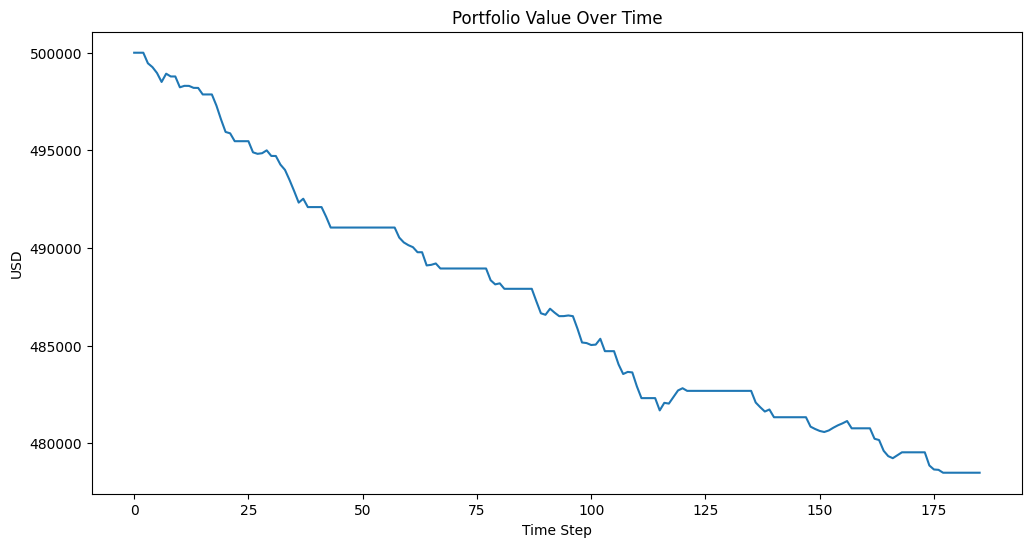

In [27]:
import matplotlib.pyplot as plt
returns_df = pd.DataFrame(portfolio_values, columns=['value'])
returns_df['daily_return'] = returns_df['value'].pct_change()
std_return = returns_df['daily_return'].std()
if std_return and not np.isnan(std_return):
    sharpe_ratio = (returns_df['daily_return'].mean() / std_return) * np.sqrt(252)
    sharpe_str = f'{sharpe_ratio:.2f}'
else:
    sharpe_str = 'N/A (insufficient return variance)'
peak = returns_df['value'].expanding(min_periods=1).max()
drawdown = (returns_df['value'] - peak) / peak
max_drawdown = drawdown.min()
print(f'Final Portfolio Value: ${portfolio_values[-1]:,.2f}')
print(f'Total Return: {(portfolio_values[-1] - INITIAL_CASH) / INITIAL_CASH * 100:.2f}%')
print(f'Annualized Sharpe Ratio: {sharpe_str}')
print(f'Maximum Drawdown: {max_drawdown*100:.2f}%')
plt.figure(figsize=(12, 6))
plt.plot(returns_df['value'])
plt.title('Portfolio Value Over Time')
plt.ylabel('USD')
plt.xlabel('Time Step')
plt.show()

## 6. Feature Importance
Let's see which features were most important to the model.

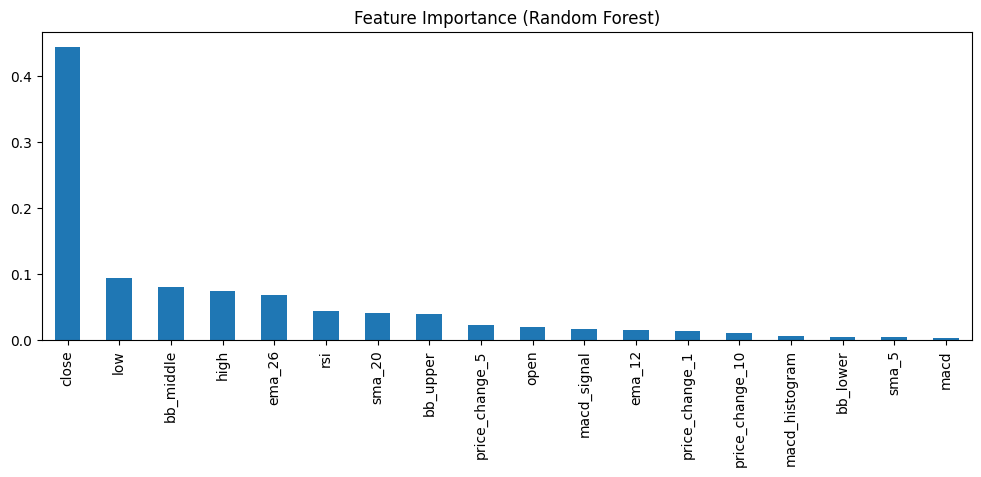

In [20]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 4), title='Feature Importance (Random Forest)')
plt.show()

## 7. Conclusion
- We built a realistic, explainable Bitcoin trading bot.
- We engineered features, trained a model, and simulated trading with fees and slippage.
- We visualized performance and feature importance.

**Next steps:** Try more advanced models, add more features, or connect to a live trading API!